# Detection of Malaria Cell with Artificial Convolutional Network

## Objective - Classifying Malaria Cell Images into Parasitic and Non-Parasitic

## Install required libraries

In [1]:
#Library for dowloading dataset from kaggle
!pip install opendatasets -q

## Import Required Libraries

In [2]:
import opendatasets as od
import os
import shutil
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator

In [3]:
import numpy as np
from sklearn.metrics import confusion_matrix

In [45]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense
from keras.preprocessing import image

## Download the dataset

In [46]:
od.download('https://www.kaggle.com/datasets/iarunava/cell-images-for-detecting-malaria')

Skipping, found downloaded files in "./cell-images-for-detecting-malaria" (use force=True to force download)


In [6]:
path='./cell-images-for-detecting-malaria/cell_images'

## Displaying some of the images from dataset

(148, 142, 3)


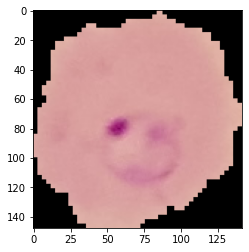

In [7]:
image = plt.imread('./cell-images-for-detecting-malaria/cell_images/Parasitized/C100P61ThinF_IMG_20150918_144104_cell_162.png')
print(image.shape)
plt.imshow(image)

## Data Preprocessing

In [8]:
os.listdir(path)

['Parasitized', 'Uninfected', 'cell_images']

cell_images folder is empty so we are removing this folder

In [9]:
shutil.rmtree(path+'/cell_images')

### Moving two images to seprate folder for final test purpose

In [10]:
os.mkdir('test')
shutil.move(path+'/Parasitized/C100P61ThinF_IMG_20150918_144104_cell_169.png', './test/')
shutil.move(path+'/Uninfected/C100P61ThinF_IMG_20150918_144104_cell_25.png', './test/')

'./test/C100P61ThinF_IMG_20150918_144104_cell_25.png'

### Data Preparation

#### Data Genrator for training and validation

In [11]:
train_datagen = ImageDataGenerator(rescale = 1./255,shear_range = 0.2,
                                   zoom_range = 0.2,horizontal_flip = True,
                                   vertical_flip=True,validation_split=0.2)

In [12]:
train_generator = train_datagen.flow_from_directory(
    path,
    target_size=(142, 148),
    batch_size=32,
    class_mode='binary',
    subset='training') # set as training data

validation_generator = train_datagen.flow_from_directory(
    path, # same directory as training data
    target_size=(142, 148),
    batch_size=32,
    class_mode='binary',
    subset='validation')

Found 22046 images belonging to 2 classes.
Found 5510 images belonging to 2 classes.


#### Unshuffled validation data for accuracy matrix

In [13]:
test_generator = train_datagen.flow_from_directory(
    path, # same directory as training data
    target_size=(142, 148),
    batch_size=32,
    class_mode='binary',
    subset='validation',
    shuffle=False)

Found 5510 images belonging to 2 classes.


Check the generator classes of train data

In [14]:
train_generator.class_indices

{'Parasitized': 0, 'Uninfected': 1}

## Building a Convolution neural network

In [22]:
#Sequential provides training and inference features on this model.
cnn = Sequential()


#Convolution layer
cnn.add(Conv2D(filters=32, kernel_size=3, activation='relu', input_shape=[142, 148, 3]))
#ouput shape : (140, 146, 32)

#Downsamples the input along its spatial dimensions (height and width) by taking the maximum value over an input window (of size defined by pool_size) for each channel of the input. 
#The window is shifted by strides along each dimension.
cnn.add(MaxPool2D(pool_size=2, strides=2))
#ouput shape : (70, 73, 32)


cnn.add(Flatten())
#ouput shape : (163520)

#Dense implements the operation: output = activation(dot(input, kernel) + bias) where activation is the element-wise activation function passed as the activation argument
#, kernel is a weights matrix created by the layer
cnn.add(Dense(units=300, activation='relu'))

#Output layer
cnn.add(Dense(units=1, activation='sigmoid'))

### Compiling ANN

In [23]:
cnn.compile(optimizer ='adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

### Training our neural network on GPU

In [24]:
with tf.device(tf.DeviceSpec(device_type="GPU", device_index=1)):
  history=cnn.fit(x = train_generator, validation_data = validation_generator, epochs = 5,workers=4)

Epoch 1/5
689/689 [==============================] - 161s 214ms/step - loss: 0.7360 - accuracy: 0.6962 - val_loss: 0.5068 - val_accuracy: 0.8127
Epoch 2/5
689/689 [==============================] - 173s 251ms/step - loss: 0.4102 - accuracy: 0.8597 - val_loss: 0.4614 - val_accuracy: 0.8940
Epoch 3/5
689/689 [==============================] - 149s 215ms/step - loss: 0.3184 - accuracy: 0.8988 - val_loss: 0.2962 - val_accuracy: 0.9049
Epoch 4/5
689/689 [==============================] - 155s 225ms/step - loss: 0.2294 - accuracy: 0.9226 - val_loss: 0.2441 - val_accuracy: 0.9020
Epoch 5/5
689/689 [==============================] - 143s 207ms/step - loss: 0.2070 - accuracy: 0.9305 - val_loss: 0.2222 - val_accuracy: 0.9289


## Model Evaluation

### Epoch Vs. Loss

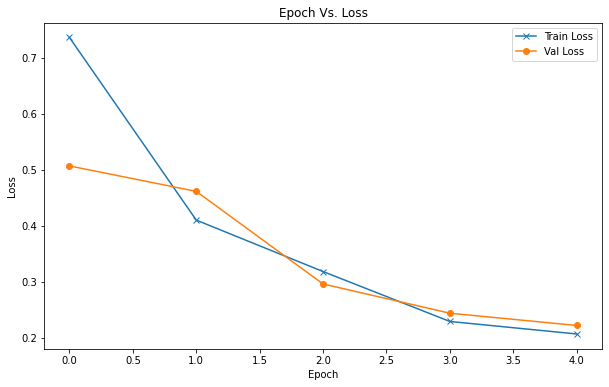

In [35]:
plt.figure(figsize=(10,6))
plt.plot(history.history['loss'],'-x');
plt.plot(history.history['val_loss'],'-o')
plt.legend(['Train Loss','Val Loss'])
plt.title('Epoch Vs. Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch');

### Epoch Vs. Accuracy

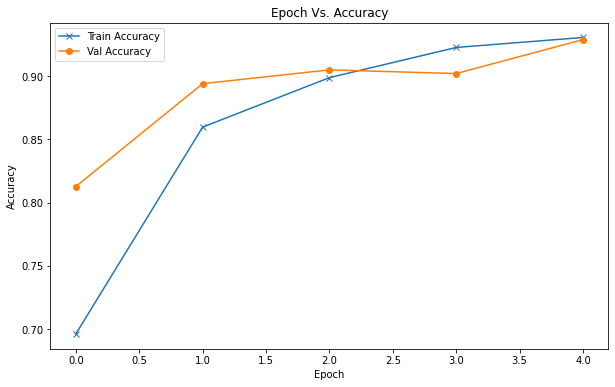

In [36]:
plt.figure(figsize=(10,6))
plt.plot(history.history['accuracy'],'-x');
plt.plot(history.history['val_accuracy'],'-o')
plt.legend(['Train Accuracy','Val Accuracy'])
plt.title('Epoch Vs. Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch');

### Confusion matrix

In [37]:
predictions = cnn.predict(test_generator)

In [38]:
y_pred = np.array([1 * (x[0]>=0.5) for x in predictions])

In [39]:
y_true=test_generator.classes

In [40]:
confusion_matrix(y_true, y_pred)

array([[2517,  238],
       [ 168, 2587]])

In [41]:
from sklearn.metrics import precision_score, recall_score, accuracy_score

## Model Evaluation Score

In [42]:
print('Accuracy Score : ', accuracy_score(y_true,y_pred))
print('Precision Score : ', precision_score(y_true,y_pred))
print('Recall Score : ', recall_score(y_true,y_pred))

Accuracy Score :  0.9263157894736842
Precision Score :  0.9157522123893805
Recall Score :  0.9390199637023593


## Prediction with single images

In [47]:
def single_pred(path_to_img):
  test_image = image.load_img(path_to_img, target_size = (142, 148))
  test_image = image.img_to_array(test_image)
  test_image = np.expand_dims(test_image, axis = 0)
  result = cnn.predict(test_image,)
  if result[0][0] >= 0.5:
    prediction = 'Uninfected'
  else:
    prediction = 'infected'

  return prediction


In [48]:
prediction=single_pred('/content/cell-images-for-detecting-malaria/cell_images/Uninfected/C100P61ThinF_IMG_20150918_144348_cell_131.png')
prediction

'Uninfected'

## Gradio Dashboard

In [49]:
!pip install gradio -q

     |████████████████████████████████| 5.1 MB 29.2 MB/s 
     |████████████████████████████████| 57 kB 4.7 MB/s 
     |████████████████████████████████| 140 kB 61.8 MB/s 
     |████████████████████████████████| 2.3 MB 67.9 MB/s 
     |████████████████████████████████| 272 kB 66.7 MB/s 
     |████████████████████████████████| 54 kB 2.6 MB/s 
     |████████████████████████████████| 84 kB 3.5 MB/s 
     |████████████████████████████████| 212 kB 67.6 MB/s 
     |████████████████████████████████| 84 kB 3.0 MB/s 
     |████████████████████████████████| 1.1 MB 58.9 MB/s 
     |████████████████████████████████| 144 kB 61.9 MB/s 
     |████████████████████████████████| 271 kB 74.5 MB/s 
     |████████████████████████████████| 94 kB 3.1 MB/s 
     |████████████████████████████████| 63 kB 1.8 MB/s 
     |████████████████████████████████| 80 kB 8.5 MB/s 
     |████████████████████████████████| 68 kB 7.3 MB/s 
     |████████████████████████████████| 54 kB 3.2 MB/s 
     |██████████████████████████

In [50]:
import gradio as gr

In [51]:
def pred_img(img):
  test_image = image.img_to_array(img)
  test_image = np.expand_dims(test_image, axis = 0)
  result = cnn.predict(test_image,)
  if result[0][0] >= 0.5:
    prediction = 'Uninfected'
  else:
    prediction = 'infected'

  return prediction

In [52]:
demo = gr.Interface(pred_img, gr.Image(shape=(142, 148)), outputs="text",title='Malaria Cell Detection')

demo.launch()

Colab notebook detected. To show errors in colab notebook, set `debug=True` in `launch()`
Running on public URL: https://50028.gradio.app

This share link expires in 72 hours. For free permanent hosting, check out Spaces (https://huggingface.co/spaces)


(<gradio.routes.App at 0x7f53400cd310>,
 'http://127.0.0.1:7860/',
 'https://50028.gradio.app')